# initial expected loss check:
at initialization, we expect a loss value stands for uniform distribution, but not some one prefer another one
eg, we have 27 characters, we want prob = 1/27
so, loss = -log(1/27) = 3.2958

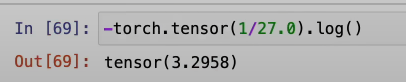

# this is a template for creating table, not relevant to the tut  : )


| Header 1 | Header 2 | Header 3 |
|----------|----------|----------|
| Row 1    | Data 1   | Data 2   |
| Row 2    | Data 3   | Data 4   |
